In [22]:
# importing necessary packages

import os
import re
import emoji
import pandas as pd
import numpy as np
import json
import ijson

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from string import punctuation
from wordcloud import WordCloud 

sw = stopwords.words("english")

# for modeling, topic modeling

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [10]:
## Reading in files from last two notebooks

all_df = pd.read_csv('cleaned_vape_tweets.csv')
openai_df = pd.read_csv('tweet_data_labled.csv')

In [11]:
openai_df.head()

,text,sentiment
0,in other news..... whats the 3-day sales analy...,True
1,"At this point, I don't know where the Blu eCig...",False
2,Frustrating! Everyone should support the switc...,True
3,Alternative Medicine: Blu eCig promotes 'freed...,False
4,.@njoyecigs welcomes new ecig regulations --&g...,False


In [57]:
all_df['vader_lem']

0         positive
1         negative
2         positive
3         negative
4         negative
            ...   
249995     neutral
249996    negative
249997    positive
249998     neutral
249999     neutral
Name: vader_lem, Length: 250000, dtype: object

In [9]:
def process_data(data):
    documents = []
    stemmer = WordNetLemmatizer()

    for sen in range(0, len(data)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(data[sen]))    
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)    
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)    
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)    
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)    
        # getting rid of HTML special entities that start with "&"
        document = re.sub(r'(&\w*)', '', document)
        
        # getting rid of links
        document = re.sub(r'(https?:\/\/.*[\r\n]*)', '', document)
        
        # getting rid of single characters
        document  = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        
        # getting rid of 'rts' and other observations
        document  = re.sub(r'(rt)', '', document)

        # Converting to Lowercase
        document = document.lower()    
        # Lemmatization
        document = document.split()
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)    
        documents.append(document)
    return documents

### Creating a classifier with openai_tweets

<AxesSubplot:>

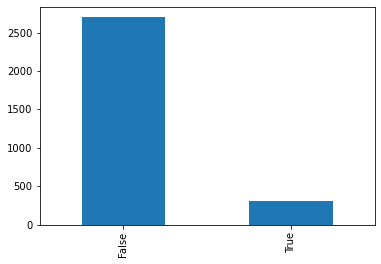

In [24]:
openai_df['sentiment'].value_counts().plot(kind='bar')

There is class imbalance with these tweets. We will use SMOTE to deal with this; a downsample would leave too much data, as our set would now be less than 1000, and, while adding synthetic data may add bias, it is necessary to balance the classes

In [13]:
# Splitting X and y data

y = openai_df['sentiment']
X = openai_df['text']

## pre-processing data

text_arr_OA = process_data(X)

In [17]:
tfidfconverter_OA = TfidfVectorizer(max_features=1500, stop_words=sw)
X_OA = tfidfconverter_OA.fit_transform(text_arr_OA).toarray()

In [32]:
from imblearn.over_sampling import SMOTE
## SMOTE

oversample = SMOTE()
X_OA, y = oversample.fit_resample(X_OA, y)

In [33]:
len(y)

5394

There is now 5394 tweets we are working with; 2394 are artificial.

In [34]:
# splitting data
# first will test on our own data; then will train on all data to classify the rest

X_train, X_test, y_train, y_test = train_test_split(X_OA, y, test_size=0.1, random_state=20)

In [35]:
# creating classifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [36]:
# Predicting on the test data

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

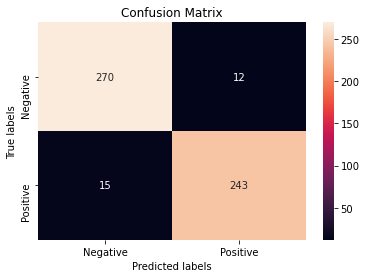

In [37]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.xaxis.set_ticklabels(['Negative','Positive']); ax.yaxis.set_ticklabels(['Negative','Positive']);
ax.set_title('Confusion Matrix');

In [38]:
print("Report model\n")
print(classification_report(y_pred, y_test))

Report model

              precision    recall  f1-score   support

       False       0.96      0.95      0.95       285
        True       0.94      0.95      0.95       255

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540



This Random Forest classification model predicts the OpenAI classification well, with accuracy, preciison, and recall all around 95%.

Now, let's retrain it on all the data

In [42]:
# creating classifier to retrain on all data

classifier_all = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier_all.fit(X_OA, y)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [41]:
# TFIDF on 

X_all = all_df['lemmetized_tweets']

text_arr_all = process_data(X_all)

tfidfconverter_all = TfidfVectorizer(max_features=1500, stop_words=sw)
X_all_tf = tfidfconverter_all.fit_transform(text_arr_all).toarray()

In [85]:
# predicting all

pred_all = classifier_all.predict(X_all_tf)

all_df['openai_sentiment'] = ['positive' if v == True else 'negative' for v in pred_all]

### Comparing classification predictions using OpenAI labels against Lexicon-based approach

[Text(0.5, 1.0, 'Vader'), Text(0.5, 0, 'Sentiment'), Text(0, 0.5, 'Count')]

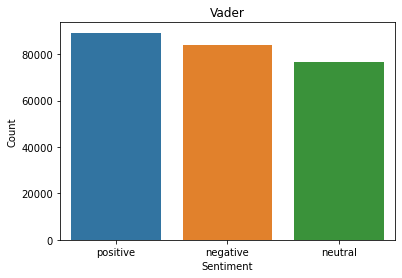

In [45]:
# Vader 

sns.countplot(x = 'vader_lem', data = all_df).set(title = "Vader", xlabel = "Sentiment", ylabel = "Count")

[Text(0.5, 1.0, 'Openai'), Text(0.5, 0, 'Sentiment'), Text(0, 0.5, 'Count')]

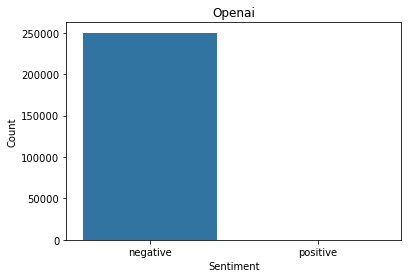

In [86]:
sns.countplot(x = 'openai_sentiment', data = all_df).set(title = "Openai", xlabel = "Sentiment", ylabel = "Count")

It seems when extrapolating OpenAI tweets to the rest, all are predicted as negative, even after fitting it on balanced data. We will then compare to the Vader Analysis with OpenAI's initial wordclouds

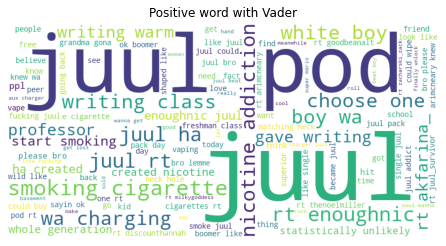

In [52]:

wordcloud = WordCloud(width = 800, height = 400, 
            background_color ='white', 
            stopwords = sw, 
            min_font_size = 10).generate(' '.join(all_df[all_df['vader_lem']=='positive']['lemmetized_tweets']))

plt.title("Positive word with Vader")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

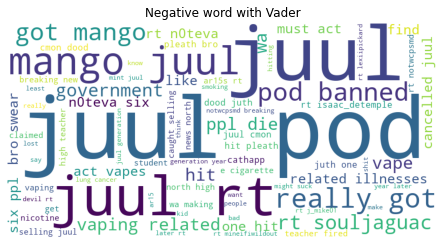

In [53]:
wordcloud = WordCloud(width = 800, height = 400, 
            background_color ='white', 
            stopwords = sw, 
            min_font_size = 10).generate(' '.join(all_df[all_df['vader_lem']=='negative']['lemmetized_tweets']))

plt.title("Negative word with Vader")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

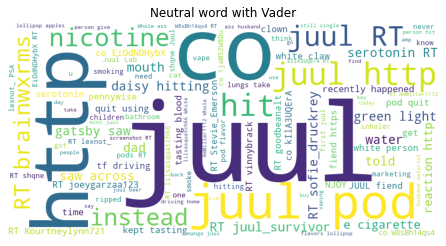

In [98]:
wordcloud = WordCloud(width = 800, height = 400, 
            background_color ='white', 
            stopwords = sw, 
            min_font_size = 10).generate(' '.join(all_df[all_df['vader_lem']=='neutral']['text']))

plt.title("Neutral word with Vader")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

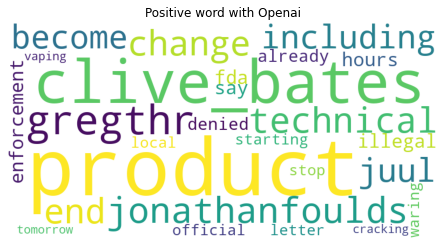

In [89]:
wordcloud = WordCloud(width = 800, height = 400, 
            background_color ='white', 
            stopwords = sw, 
            min_font_size = 10).generate(' '.join(all_df[all_df['openai_sentiment']=='positive']['lemmetized_tweets']))

plt.title("Positive word with Openai")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

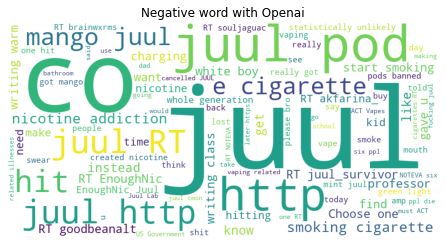

In [92]:

wordcloud = WordCloud(width = 800, height = 400, 
            background_color ='white', 
            stopwords = sw, 
            min_font_size = 10).generate(' '.join(all_df[all_df['openai_sentiment']=='negative']['text']))

plt.title("Negative word with Openai")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

### Looking back on "High Ratio" tweets

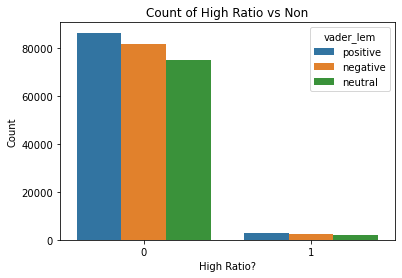

In [96]:
sns.countplot(x = 'high_ratio', 
              hue = "vader_lem", 
              data = all_df).set(title = "Count of High Ratio vs Non", xlabel = "High Ratio?", ylabel = "Count")

plt.show()

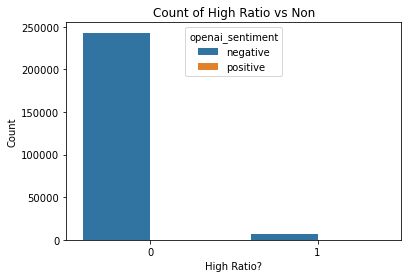

In [97]:
sns.countplot(x = 'high_ratio', 
              hue = "openai_sentiment", 
              data = all_df).set(title = "Count of High Ratio vs Non", xlabel = "High Ratio?", ylabel = "Count")

plt.show()